# Preparing and converting data

In [11]:
##tentative implémentation code Thibault

In [2]:
from collections import defaultdict
from collections import namedtuple
from collections import Counter
from tqdm import tqdm

from thibaultScript import (
    import_known_tokens,
    compile_scores#,
#    convert_raw#,
#    vjui
)

from pandas import DataFrame, Series
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [3]:
def convert_raw(gold, task_list=[], 
                form_fn=lambda x: x, 
                lemma_fn=lambda x: x, 
                pos_fn=lambda x: x,
                pos_key = "POS",
                remove_disambiguation = False
               ):
    """ Converts input data into Gold data.
        The main goal here is to treat cases like apostrophes, so that two tokens _l/'_
        became one _l'_
        And handle fucking roman numerals
    """
    temp_out = []
    pass_next = False
    
    for sentence in tqdm(gold):
        temp_sentence = []
        no_sentence_append = False
        # Handle roman numerals
        for idx,token in enumerate(sentence):
            if pass_next:
                pass_next = False
                continue
            
            new_token = {task: "_" for task in task_list}
            new_token.update({
                "form": form_fn(token["form"]),
                "lemma": lemma_fn(token["lemma"]),
                "POS": pos_fn(token[pos_key]),
            })
            # No disambiguation at the lemmatizer lever
            if remove_disambiguation and new_token["lemma"][-1].isnumeric():
                new_token["lemma"] = new_token["lemma"][:-1]
                
            if new_token["form"] in {"’", "'"} and temp_sentence:
                temp_sentence[-1]["form"] += "'"
                
            # roman numerals
            # not useful now, because we do it when loading sentences
            # but might serve someday
            elif (
                # is there a phrase before, and does it ends with .
                temp_out and temp_out[-1] and temp_out[-1][-1]["form"] == "."
                # and are we at the start of a sentence, and not the end
                and idx == 0 and idx < (len(sentence) - 1) 
                # and next token a .
                and sentence[idx+1]["form"] == '.'
                and token[pos_key].endswith("car")
            ):
                new_token["form"] = "."+new_token["form"]+"."
                temp_out[-1][-1] = new_token
                # and now some acrobatics
                pass_next = True
                temp_sentence = temp_out[-1]
                no_sentence_append = True
                
            else:
                temp_sentence.append(new_token)
        if not no_sentence_append:
            temp_out.append(temp_sentence)
    return temp_out

In [4]:
KNOWN_TOKENS, KNOWN_LEMMAS = import_known_tokens()

In [5]:
#KNOWN_TOKENS

In [6]:
#TASKS = "lemma,Deg,Numb,Person,Mood_Tense_Voice,Case,Gend,pos".split(",")
TASKS = "lemma,POS".split(",")

In [22]:
Texts = []
GOLD = defaultdict(list)

nb_tokens = 0

def filter_gold(data):
    return [lst for lst in data if lst]


import regex

punkts = regex.compile(r"\W+")
greek = regex.compile(r"\p{Greek}+")

def keep_tokens(token):
    if greek.match(token):
        print(token)
        return False
    return True

key = None
with open("nca-sample-naomicorr.tsv") as f:
    header = []
    current_text = None
    for lineno, line in enumerate(f):
        line = line.strip().split("\t")
        if lineno == 0:
            header = line
            continue
        
        line = dict(zip(header, line))
        
        if line["form"].startswith("[REF:"):
            if key:
                GOLD[key] = filter_gold(GOLD[key])
                
            key = line["form"][5:]#TODO: compléter
            
            #Texts.append((line["form"], nb_tokens, len(GOLD)))
            GOLD[key].append([])
            continue
        
        if line["POS"] == "PONfrt":
            if GOLD[key][-1] != []:
                # And now for some more Roman Numerals
                if GOLD[key][-1][-1]["POS"].endswith("car") and line["form"] == '.':
                    GOLD[key][-1].append(line)
                else:
                    GOLD[key][-1].append(line)
                    GOLD[key] = filter_gold(GOLD[key])
                    GOLD[key].append([])
        elif keep_tokens(line["form"]):
            GOLD[key][-1].append(line)
            nb_tokens += 1
            

if GOLD[key][-1] == []:
    GOLD[key] = GOLD[key][:-1]
print(f"{len(GOLD)} texts found")
print(f"{sum([len(t) for t in GOLD.values()])} sentences found")
# Compute texts Lengths
#for cur, nxt in zip(Texts, Texts[1:] + [None]):
#    if nxt is None:
#        TextsLengths[cur[0]] = nb_tokens - cur[1]
#    else:
#        TextsLengths[cur[0]] = nxt[1] - cur[1]
# Update titles
#TextsTitles = {
#    urn: f"{title} ({TextsLengths.get(urn, '?')} mots)"
#    for urn, title in TextsTitles.items()
#}
#print(TextsTitles)

278 texts found
1626 sentences found


In [8]:
TextsTitles = list(GOLD.keys())
TextsTitles[0:5]

['ChastVergiS_A_69]',
 'PsLorrA_672]',
 'PerNeslesTabJ_602]',
 'MerlinP_956]',
 'MerlinP_1603]']

# Scores for full corpus

## Tagging and getting global scores

In [9]:
# Lemmatise and regroup everyting in one single value to make it work
PLATINUM = [
    sentence
    for text in GOLD
    for sentence in convert_raw(GOLD[text], form_fn = lambda x: x.replace('§', ''))
]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11507.01it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 9142.90it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 6769.69it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14463.12it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10050.25it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 32346.82it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 26800.66it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20887.97it/s]


In [10]:
TOKENS = [
    [x["form"] for x in sentence]
    for sentence in PLATINUM
]
# Vérif romains
#[t for s in TOKENS for t in s if t[0] == '.']
# vérif tokens
TOKENS[0]

['Longue',
 'atente',
 'vous',
 'poroit',
 'nuire',
 ',',
 'ce',
 "m'",
 'est',
 'vis',
 ':',
 'si',
 'lo',
 'que',
 'vous',
 'soiiés',
 'amis',
 'en',
 'un',
 'haut',
 'liu',
 ',',
 'se',
 'vous',
 'veés',
 'que',
 'vous',
 'i',
 'soiiés',
 'bien',
 'amés',
 '.']

In [11]:
TASKS

['lemma', 'POS']

In [12]:
from pie.tagger import Tagger
from pie.utils import chunks
DEVICE = "cpu"
BATCH_SIZE = 64


OUTPUT = []
TEST_NEW = True

#tagger = Tagger(device="cuda", batch_size=100, lower=False, tokenize=False)
tagger = Tagger(device=DEVICE, batch_size=BATCH_SIZE, lower=False, tokenize=False)
if TEST_NEW:
    for task in TASKS:
        tagger.add_model(f"modeles/{task}.tar", task)
#else:
#    tagger.add_model("../../../latin-lasla-models/lasla-plus.tar", *TASKS)


for chunk in tqdm(chunks([(sent, len(sent)) for sent in TOKENS], tagger.batch_size)):
    tagged, tasks = tagger.tag(*zip(*chunk))#, use_beam=True)
    OUTPUT.extend([
        [
            (token, dict(zip(tasks, result)))
            for token, result in sentence
        ]
        for sentence in tagged
    ])


fatal: ni ceci ni aucun de ses répertoires parents n'est un dépôt git : .git
It seems like you downloaded `pie` instead of git-cloning it or installing it with pip.
We won't be able to check compatibility between pretrained models and `pie` version.

25it [01:17,  3.11s/it]


In [13]:
from collections import defaultdict, Counter


RESULTS, RAW_SCORES, RAW_SCORES_NOT_EMPTY, ERRORS, SCORES_KNOWN = compile_scores(
    OUTPUT, PLATINUM, task_list=TASKS, known_tokens=KNOWN_TOKENS, known_lemmas=KNOWN_LEMMAS)

In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate
from IPython.display import HTML, display

data = [["Task", "Accuracy"]]#, "Accuracy on V != _"]]


for task, (pred, truth) in RAW_SCORES.items():
    (pred_limited, truth_limited) = RAW_SCORES_NOT_EMPTY[task]
    data.append([
        task,
        "{0:.2f}".format(accuracy_score(truth, pred)*100)#,
        #"{0:.2f}".format(accuracy_score(pred_limited, truth_limited)*100)
    ])
    
df = DataFrame([x[1:] for x in data[1:]], columns=data[0][1:], index=[x[0] for x in data[1:]]).sort_index()
display(HTML(df.to_html()))
#print(df.to_latex())

,Accuracy
POS,94.66
lemma,91.09


## Lemma scores per POS category

In [15]:
from collections import defaultdict

# Dict[Text_id, Dict[POS, [0, 1]]] where 0 = false, 1 = true
Stats_Per_Pos = defaultdict(list)
_, Scores_all2, *_, Score_Knowns = compile_scores(OUTPUT, PLATINUM, 
                                                     task_list=TASKS, known_tokens=KNOWN_TOKENS, 
                                                     known_lemmas=KNOWN_LEMMAS)

NBTOKENS = 0
NBERRORS = 0

for (lemma_pred, lemma_truth,  pos_truth) in zip(
   Scores_all2["lemma"][0],
   Scores_all2["lemma"][1],
   Scores_all2["POS"][1]
):
    Stats_Per_Pos[pos_truth].append(int(lemma_pred == lemma_truth))
    NBTOKENS +=1
    NBERRORS += int(lemma_pred != lemma_truth)


In [16]:
#LIMIT_TO_POS = {"VERcjg", "VERinf", "VERppe", "VERppa", "NOMcom", "ADJqua"}#LISTE À CONFIRMER


def compute_accuracy(trues, corpus_size, corpus_accuracy) -> int:
    return ((len(trues) - sum(trues)) / corpus_size) / corpus_accuracy

PosLemmaDetails = DataFrame([
    {
        "POS": pos, 
        "Accuracy": sum(equals) / len(equals), 
        "Error contrib %": compute_accuracy(equals, NBTOKENS, NBERRORS/NBTOKENS),
        "Support": len(equals),
        "Support relatif": len(equals) / NBTOKENS,
        "Diff contrib support": compute_accuracy(equals, NBTOKENS, NBERRORS/NBTOKENS) - len(equals) / NBTOKENS
    }
    for pos, equals in Stats_Per_Pos.items()
    #if pos in LIMIT_TO_POS
])

#Impact means: contribution to total error (in %)
# TODO: réfléchir meilleur mesure
PosLemmaDetails.sort_values("Diff contrib support", ascending=False)

,POS,Accuracy,Error contrib %,Support,Support relatif,Diff contrib support
26,NOMpro,0.078731,0.257556,851,0.024923,0.232633
1,NOMcom,0.835802,0.251314,4659,0.136448,0.114867
18,PROrel,0.788595,0.049934,719,0.021057,0.028877
0,ADJqua,0.847173,0.056833,1132,0.033153,0.023680
12,VERppe,0.869697,0.042378,990,0.028994,0.013384
20,DETcar,0.742574,0.008541,101,0.002958,0.005583
39,VERppa,0.746479,0.005913,71,0.002079,0.003834
30,ADJcar,0.578947,0.002628,19,0.000556,0.002072
22,PROind,0.890511,0.009855,274,0.008025,0.001831
47,ETR,0.000000,0.001643,5,0.000146,0.001496


## POS scores per POS category

In [17]:
from collections import defaultdict

# Dict[Text_id, Dict[POS, [0, 1]]] where 0 = false, 1 = true
Stats_Per_Pos = defaultdict(list)
_, Scores_all2, *_, Score_Knowns = compile_scores(OUTPUT, PLATINUM, 
                                                     task_list=TASKS, known_tokens=KNOWN_TOKENS, 
                                                     known_lemmas=KNOWN_LEMMAS)

NBTOKENS = 0
NBERRORS = 0

for (pos_pred, pos_truth,  pos_truth) in zip(
   Scores_all2["POS"][0],
   Scores_all2["POS"][1],
   Scores_all2["POS"][1]
):
    Stats_Per_Pos[pos_truth].append(int(pos_pred == pos_truth))
    NBTOKENS +=1
    NBERRORS += int(pos_pred != pos_truth)


PosPosDetails = DataFrame([
    {
        "POS": pos, 
        "Accuracy": sum(equals) / len(equals), 
        "Error contrib %": compute_accuracy(equals, NBTOKENS, NBERRORS/NBTOKENS),
        "Support": len(equals),
        "Support relatif": len(equals) / NBTOKENS,
        "Diff contrib support": compute_accuracy(equals, NBTOKENS, NBERRORS/NBTOKENS) - len(equals) / NBTOKENS
    }
    for pos, equals in Stats_Per_Pos.items()
    #if pos in LIMIT_TO_POS
])

#Impact means: contribution to total error (in %)
# TODO: réfléchir meilleur mesure
PosPosDetails.sort_values("Diff contrib support", ascending=False)
    

,POS,Accuracy,Error contrib %,Support,Support relatif,Diff contrib support
0,ADJqua,0.805654,0.120680,1132,0.033153,0.087527
18,PROrel,0.859527,0.055403,719,0.021057,0.034346
1,NOMcom,0.935394,0.165112,4659,0.136448,0.028665
12,VERppe,0.895960,0.056500,990,0.028994,0.027506
22,PROind,0.770073,0.034558,274,0.008025,0.026534
7,ADVgen,0.929655,0.083928,2175,0.063699,0.020229
26,NOMpro,0.908343,0.042787,851,0.024923,0.017863
20,DETcar,0.643564,0.019748,101,0.002958,0.016790
37,PROimp,0.375000,0.010971,32,0.000937,0.010034
34,ADJind,0.655738,0.011519,61,0.001786,0.009733


In [41]:
# Get some confusion matrix
confMat = defaultdict(Counter)

for (pos_pred, pos_truth) in zip(
   Scores_all2["POS"][0],
   Scores_all2["POS"][1]
):
    if pos_pred != pos_truth:
        confMat[pos_truth][pos_pred] += 1
    
#confMat

confMatDf = pd.DataFrame(confMat).transpose().fillna(0)
#confMatDf = confMatDf.loc[(confMatDf.sum(axis=1) > 50), (confMatDf.sum(axis=0) > 50)]
confMatDf = confMatDf.loc[(confMatDf.sum(axis=1) > 99), (confMatDf.sum(axis=0) > 99)]
confMatDf.sort_index().sort_index(axis=1).astype(int)

,ADJqua,ADVgen,CONsub,NOMcom,VERcjg,VERppe
ADJqua,0,22,0,101,19,20
ADVgen,16,0,12,30,17,5
NOMcom,79,36,0,0,40,45
PROrel,0,6,82,0,0,0
VERcjg,13,15,0,72,0,23
VERppe,11,4,0,37,40,0


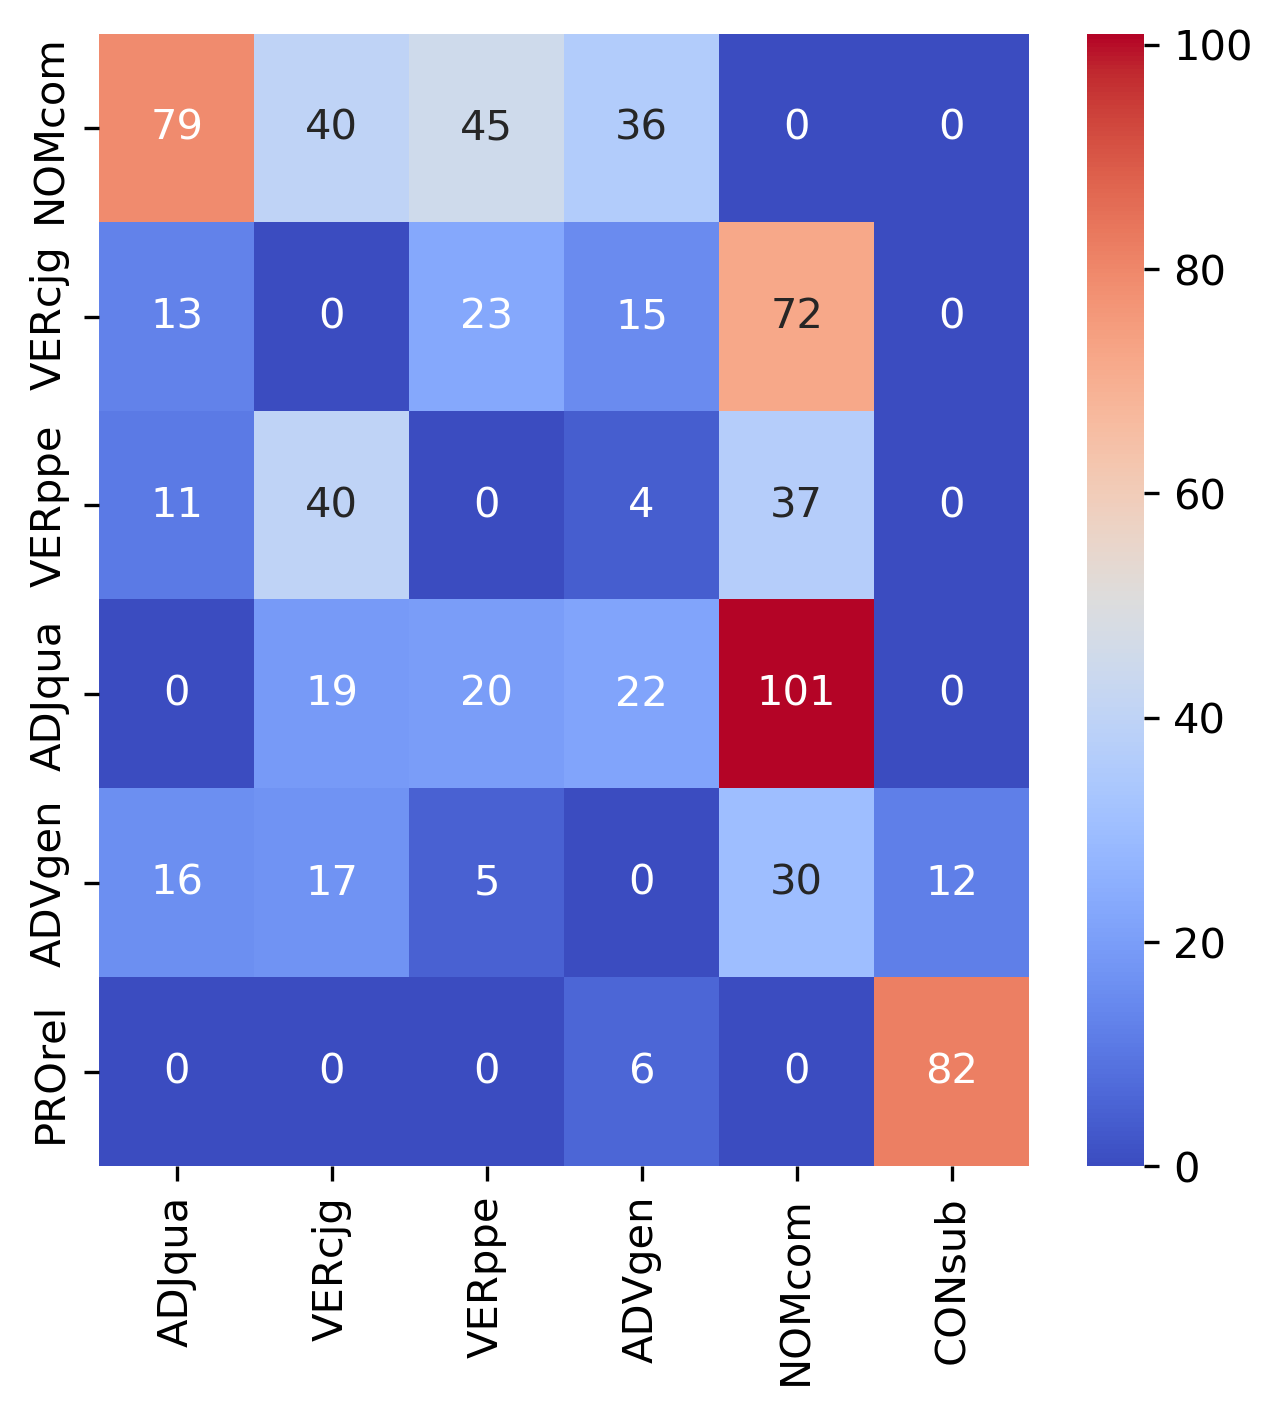

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
ax = sns.heatmap(confMatDf, annot=True, fmt=".0f", cmap = "coolwarm")

# Scores by text, scripta, genre

## Get metadata and annotate texts individually

## Scripta vs genre heatmap

## Lemma and POS per scripta

## Lemma and POS per genre

In [243]:
Impact_Acc_Per_Pos3["error"] = Impact_Acc_Per_Pos3[1].str.extract(r'\(Error Rate: (.*)%\)')
Impact_Acc_Per_Pos3.index = Impact_Acc_Per_Pos3[0].str.extract(r'\[REF:(.*)\]')
Impact_Acc_Per_Pos3
type(Impact_Acc_Per_Pos3)
#Impact_Acc_Per_Pos3["error"]

pandas.core.frame.DataFrame

In [130]:
Impact_Acc_Per_Pos3[Impact_Acc_Per_Pos3["error"]].astype(float)

KeyError: 'error'

In [239]:
Impact_Acc_Per_Pos4 = Impact_Acc_Per_Pos3["error"]
Impact_Acc_Per_Pos4
dfPlot = Impact_Acc_Per_Pos4[Impact_Acc_Per_Pos4.columns].astype(float)

AttributeError: 'Series' object has no attribute 'columns'

In [216]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
fig = plt.figure(figsize=(10,10))
cmap = sns.cubehelix_palette(250, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
ax = sns.heatmap(Impact_Acc_Per_Pos4, annot=True)#, cmap=cmap)
ax.set_title("Pourcentage d'erreurs occasionnées par POS")
fig.show()

IndexError: Inconsistent shape between the condition and the input (got (62, 1) and (62,))

<Figure size 720x720 with 0 Axes>

In [223]:
TextTitleSize[text_id].size
TextTitleSize[text_id].error_rate
Stats_Per_Pos.items

<function defaultdict.items>

In [237]:
ScatterPos = DataFrame([
    {
        "POS": pos,
        "Corpus": len(equals)/TextTitleSize[text_id].size, 
        "desErreurs": compute_accuracy(
            equals,
            TextTitleSize[text_id].size,
            TextTitleSize[text_id].error_rate
        )
    }
    for text_id, texts_values in Stats_Per_Pos.items()
        for pos, equals in texts_values.items()
        if pos in LIMIT_TO_POS
])

ScatterPos
#ScatterPos["Impact"] = ScatterPos["% des Erreurs"] / ScatterPos["% Corpus"] 

#texts_values.items
Stats_Per_Pos.items()

dict_items([(0, defaultdict(<class 'list'>, {'_': [1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1]})), (1, defaultdict(<class 'list'>, {'_': [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]})), (2, defaultdict(<class 'list'>, {'_': [1,

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7), dpi=300)
# Draw plotbot
ScatterPos.boxplot(ax=ax1, column="Impact", by="POS")
ax1.set_title(label="")
ax1.axhline(y=1, label="Distribution normale", linestyle=":")
ax1.set_ylabel("Impact")
# ax1.text(y=0.8, x=5.6, s="Distribution\nnormale")
ax1.grid(True, color='b', linestyle='--', linewidth=0.2)

# Draw scatter
ax2 = sns.scatterplot(
    x="% Corpus", y="% des Erreurs", style="POS", 
    data=ScatterPos, alpha=0.8,
    color="g",
    ax=ax2
)
x = np.linspace(0, 0.4)
line = ax2.plot(x, x, linestyle=':', color="b", label="Distribution\nnormale")
# line_patch = mpatches.Patch(color='blue', linestyle="--", label="Distribution\nnormale")

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0, handles=handles)

fig.suptitle("")
fig.show()

nompro =  ScatterPos.loc[ScatterPos["POS"]=="NOMpro"]["Impact"]
print(nompro.median())#, nompro)
nomcom =  ScatterPos.loc[ScatterPos["POS"]=="NOMcom"]["Impact"]
print(nomcom.median())#, nomcom)
ver =  ScatterPos.loc[ScatterPos["POS"]=="VER"]["Impact"]
print(nomcom.median())#, nomcom)

FullDistrib = DataFrame([
    {
        "POS": pos,
        "% Corpus": len(equals)/TextTitleSize[text_id].size, 
        "% des Erreurs": compute_accuracy(
            equals,
            TextTitleSize[text_id].size,
            TextTitleSize[text_id].error_rate
        )
    }
    for text_id, texts_values in Stats_Per_Pos.items()
        for pos, equals in texts_values.items()
])
FullDistrib["Impact"] = ScatterPos["% des Erreurs"] / ScatterPos["% Corpus"]
FDGB = FullDistrib.groupby("POS").median()
print(FDGB)



sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

DF_Tardif = DataFrame(SPLITS_TASK, index=[
    #"{} ({} mots)".format(TextsTitles[tid], length) for (tid, *_), length in zip(MilestonesSentences, SIZES)
    "{} ({} mots)".format(TextsTitles[0], length) for (*_), length in zip(MilestonesSentences, SIZES)
])

plt.figure(figsize=(10,10))
cmap = sns.cubehelix_palette(250, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
ax = sns.heatmap(DF_Tardif, annot=True, cmap=cmap)



MilestonesSentences[1][0]
#MILESTONES
#SIZES
#TextsTitles[tid]
#TextsTitles